In [1]:
%load_ext autoreload
%autoreload 2

# DSL for curve fit inference

As part of the `genjax.interpreted` performance investigation, I wanted to investigate a DSL for the curve-fitting task which could achieve JAX-accelerated performance without introducing JAX concepts such as the Switch and Map combinators, `in_axes`, and other things that might complicate the exposition of inference for the newcomer. While doing so, I also studied ways to "automatically" thread randomness through the computation without having to discuss the careful use of `jax.random.split` which we recommend to GenJAX users. Having done the experiment, I have mixed feelings about the results: on the one hand, it is possible to get JAX-level performance with curve-building combinators, but the price of so doing is that the GFI is hidden from view as well, and that may be too far a step. Nonetheless, if you're still interested in what can be achieved in this framework, read on!

In [2]:
import genjax
import genjax.typing
import jax
import jax.numpy as jnp
import jax.tree
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from blocks import (
    Block,
    BlockFunction,
    CoinToss,
    CurveFit,
    Exponential,
    Periodic,
    Polynomial,
)

console = genjax.console()

The `blocks` library is concentrated on a simple $\mathbb{R}\rightarrow\mathbb{R}$ inference problem, localized to the unit square for convenience, as found in the introductory GenJAX notebooks. We provide a "basis" of polynomial, $ae^{bx}$, and $a\sin(\phi + 2\pi x/T)$ functions, each of whose parameters are drawn from a standard distribution that the user supplies. The intro curve fit task contemplates a polynomial of degree 2 with normally distributed coefficients, which we may write as

In [3]:
P = Polynomial(max_degree=2, coefficient_d=genjax.normal(0.0, 1.0))

Note one felicity we have achieved already: we can specify the normal distribution in a simple fashion without having to tuple the arguments or provide randomness: that comes later. The type of `P` is `Block`, a name inspired by [blockly](https://developers.google.com/blockly). The only operation we can do on a Block is request an array of samples from it.

In [4]:
p = P.sample()
console.print(p.get_choices())

(HierarchicalChoiceMap)
└── :p
    └── (HierarchicalChoiceMap)
        └── :coefficients
            └── (ChoiceValue)
                └──  f32[1,3]

The trace contains choices and a return value. In the blocks DSL, the return value is a JAX-compatible native Python function representing the sampled polynomial $x\mapsto p(x)$. Calling it with the value 0.0 will reveal the constant term:

In [5]:
p.get_retval()(0.0)

Array([-0.5786848], dtype=float32)

You may have noticed an extra layer of brackets around the polynomial's coefficients and its return value. This is the magic of JAX: sampling from a block produces an "array BlockFunction". Such an array of functions, when presented with an argument, will return an array of values (one for each function evaluated at that single argument.)

Here's a simple function that will plot a bundle of samples from a block. In this case, we will want to provide a vector of arguments to each function (points along the $x$ axis). Since BlockFunctions are JAX-compatible, we can use `jax.vmap` for that. Now, the functions which already knew how to act as a vector given one argument can act that way across a vector of arguments, producing a grid of points, all in one step.

In [6]:


def plot_functions(ax: Axes, fns: BlockFunction, **kwargs):
    x = jnp.linspace(-1, 1, 200)
    ax.axis((-1, 1, -1, 1))
    yss = jax.vmap(fns)(x)
    for y in yss.T:
        ax.plot(x, y, **kwargs)

def plot_priors(B: Block, n: int):
    fig, ax = plt.subplots(figsize=(4, 4))
    return plot_functions(ax, B.sample(n).get_retval())

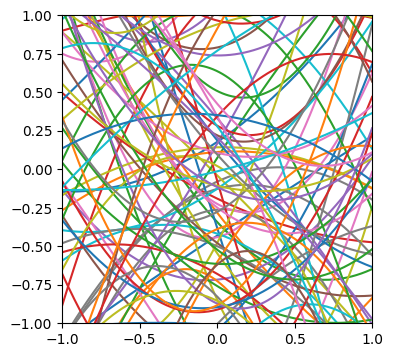

In [7]:
plot_priors(P, 100)

We can do the same for our Periodic and Exponential distributions:

In [8]:
Q = Periodic(
    amplitude=genjax.beta(2.0, 5.0),
    phase=genjax.uniform(-1.0, 1.0),
    period=genjax.normal(1.0,1.0)
)

R = Exponential(
    a=genjax.normal(0.0, 1.0),
    b=genjax.normal(0.0, 1.0)
)

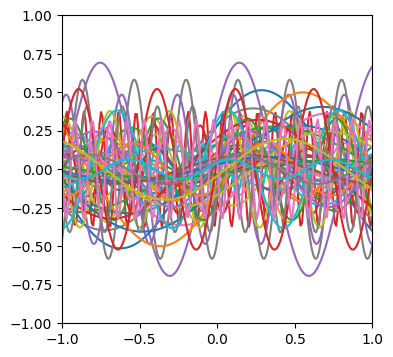

In [9]:
plot_priors(Q, 50)

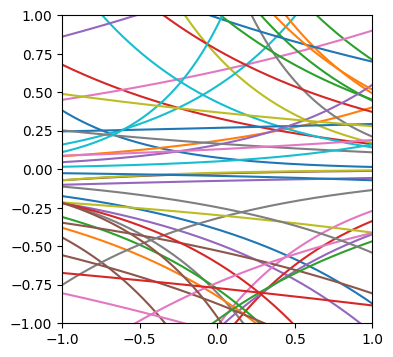

In [10]:
plot_priors(R, 50)

`Block` objects support the pointwise operations $+, *$ as well as `@` (function composition). Vikash's favorite ascending-periodic function might be modeled by the sum of a polynomial and a periodic function which we can write simply as $P+Q$:

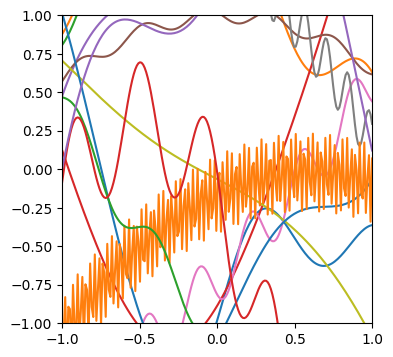

In [11]:
plot_priors(P + Q, 15)

It does seem like the goal function lies in the span of the prior distribution in this case. (I pause here to note that pointwise binary operations in `Block` are not commutative as you might expect, because the randomness supplied by `sample` is injected left to right).

The binary operations produce traces representing the expression tree that created them:

In [12]:
console.print((P+Q).sample().get_choices())

(HierarchicalChoiceMap)
├── :l
│   └── (HierarchicalChoiceMap)
│       └── :p
│           └── (HierarchicalChoiceMap)
│               └── :coefficients
│                   └── (ChoiceValue)
│                       └──  f32[1,3]
└── :r
    └── (HierarchicalChoiceMap)
        ├── :T
        │   └── (ChoiceValue)
        │       └──  f32[1]
        ├── :a
        │   └── (ChoiceValue)
        │       └──  f32[1]
        └── :φ
            └── (ChoiceValue)
                └──  f32[1]

Even if we don't appear to be using the GFI, we still have traces. The final step in this demo is to conduct an importance sample at JAX speed given a set of points. It's at this point that we want to create a model that supports the concept of outlier. In the original examples, the model tossed a Bernoulli coin, and selected between polynomials with a loose and tight variance. Vikash has elsewhere proposed switching between a normal and uniform distribution in this case, which we will attempt here. This is the point at which we run into the "if problem" of JAX, which we finesse using a `CoinToss` block (a better name might be `BernoulliChoice`, but we're just sketching here.)

In [13]:
ct = CoinToss(
    probability=0.2,
    heads=Polynomial(max_degree=1, coefficient_d=genjax.normal(0.0, 0.05)),
    tails=Polynomial(max_degree=1, coefficient_d=genjax.normal(1.0, 0.05))
)

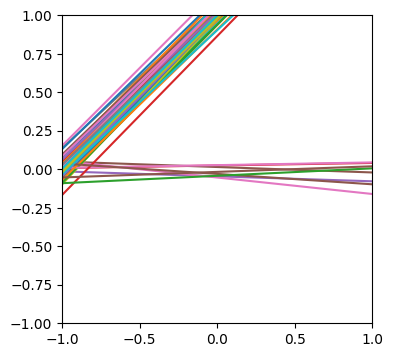

In [14]:
plot_priors(ct, 50)

Having assembled these pieces, let's turn to the inference task. This begins with a set of $x, y$ values with an outlier installed.

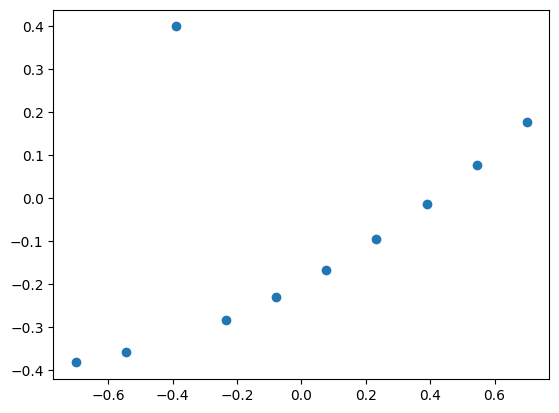

In [15]:
xs = jnp.linspace(-0.7, 0.7, 10)
ys = -0.2 + 0.4 * xs + 0.2 * xs**2
ys = ys.at[2].set(0.4)

plt.scatter(xs, ys)

We use a object called `CurveFit` to get an importance sample. Internally, `CurveFit` is written in terms of the map and switch combinators. That constructor will need simple GenerativeFunctions for the inlier and outlier models. I considered sticking with my design decision before of requiring the user to supply these in terms of the primitive distributions like `genjax.normal`, but instead, since the GFs are so simple, we may was well just write them down:

The alternative might have been to let the user say, for example,
```Python
lambda y: genjax.normal(y, 0.1)
```
in the first instance, and that would avoid presenting the decorator, `@`, and a couple of other things this notebook hasn't talked about yet.

In [16]:
p_outlier = genjax.beta(1.0, 1.0)
sigma_inlier = genjax.uniform(0.0, 0.3)
curve_fit = CurveFit(
    curve=P,
    sigma_inlier=sigma_inlier,
    p_outlier=p_outlier
)

We'll need a function to render the sample from the posterior: since, behind the scenes, Jax has turned the BlockFunctions into BlockFunctions of vectors of parameters, that code will be in terms of `tree_map`. 

In [17]:
def plot_posterior(tr: genjax.Trace, xs: genjax.typing.FloatArray, ys: genjax.typing.FloatArray):
    fig, ax = plt.subplots(figsize=(4, 4))
    plot_functions(ax, tr.get_subtrace('curve').get_retval(), alpha=0.1)
    ax.scatter(xs, ys)

All that remains is to generate the sample. We select $K$ samples from a posterior categorical distribution taken over $N$ samples. On my home Mac, whose GPU is not accessible to GenJAX, I can get $N=100\mathrm{k}$ importance samples in a few seconds! Recall that on GenJAX interpreted, each of these took a substantial fraction of second. From there, we can plot, say, $K=100$ of these with alpha blending to visualize the posterior.

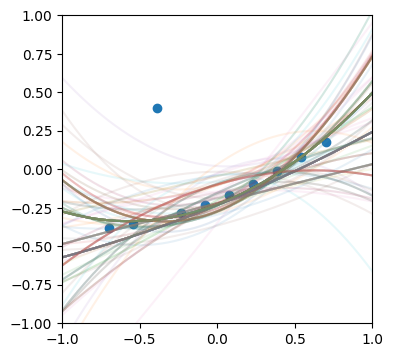

In [18]:
tr = curve_fit.importance_sample(xs, ys, 100000, 200)
plot_posterior(tr, xs, ys)

This is an excellent result, thanks to GenJAX, and I think indicative of what can be done with a DSL to temporarily shift the focus away from the nature of JAX. In this version of the model, the inlier sigma and probability were inference parameters of the model. Let's examine the distributions found by this inference:

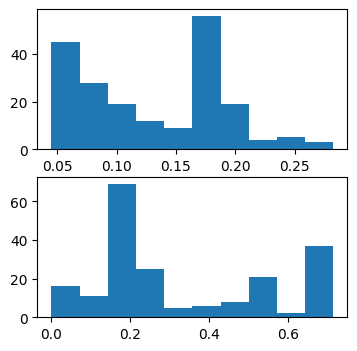

In [19]:
def param_histo(tr):
    fig, ax = plt.subplots(2, figsize=(4, 4))
    ax[0].hist(tr.get_choices()['sigma_inlier'])
    ax[1].hist(tr.get_choices()['p_outlier'])

param_histo(tr)

While we're at it, we can generate summary statistics on the various parameters, to improve the fit.

In [20]:
coefficients = tr.get_choices()['curve', 'p', 'coefficients']
means = jnp.mean(coefficients, axis=0)
stdevs = jnp.sqrt(jnp.var(coefficients, axis=0))
means, stdevs

(Array([-0.2090162 ,  0.37543848,  0.18435487], dtype=float32),
 Array([0.06749534, 0.11909322, 0.30313504], dtype=float32))

equipped with that information, we could make a better prior:

In [21]:
updated_distributions = list(map(genjax.normal, means, stdevs))
#P2 = Polynomial(max_degree=2, coefficient_d=[genjax.normal(means[0], stdevs[0]), genjax.normal(means[0], stdevs[0]), genjax.normal(means[1], stdevs[1])])
updated_distributions

[SugaredGenerativeFunctionCall(
   gen_fn=TFPDistribution(
     make_distribution=<class 'tensorflow_probability.substrates.jax.distributions.normal.Normal'>
   ),
   args=(f32[], f32[]),
   kwargs={}
 ),
 SugaredGenerativeFunctionCall(
   gen_fn=TFPDistribution(
     make_distribution=<class 'tensorflow_probability.substrates.jax.distributions.normal.Normal'>
   ),
   args=(f32[], f32[]),
   kwargs={}
 ),
 SugaredGenerativeFunctionCall(
   gen_fn=TFPDistribution(
     make_distribution=<class 'tensorflow_probability.substrates.jax.distributions.normal.Normal'>
   ),
   args=(f32[], f32[]),
   kwargs={}
 )]


Maybe we can stretch to accommodate a periodic sample:

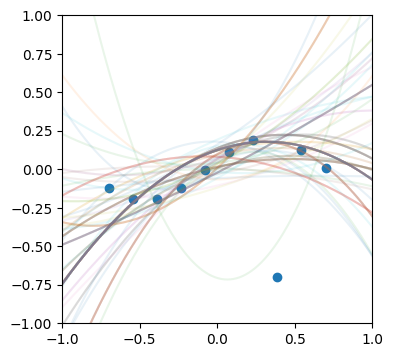

In [22]:
def periodic_ex(F: Block):
    ys = (0.2 * jnp.sin(4 * xs + 0.3)).at[7].set(-0.7)
    fs = CurveFit(
        curve=F,
        sigma_inlier=sigma_inlier,
        p_outlier=p_outlier
    ).importance_sample(xs, ys, 100000, 100)
    plot_posterior(fs, xs, ys)

periodic_ex(P)

Though the sample points are periodic, we supplied the degree 2 polynomial prior, and got reasonable results quickly. Before trying the Periodic prior, we might try degree 3 polynomials, and see what we get:

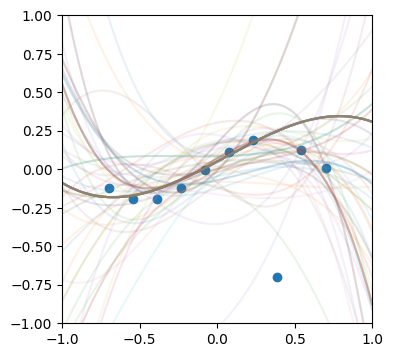

In [23]:
periodic_ex(Polynomial(max_degree=3, coefficient_d=genjax.normal(0.0, 1.0)))

**LGTM!** 
Now for periodic prior.

(NB: your results may vary, but if you see some darker lines this is because the importance sampling is done *with replacement*)

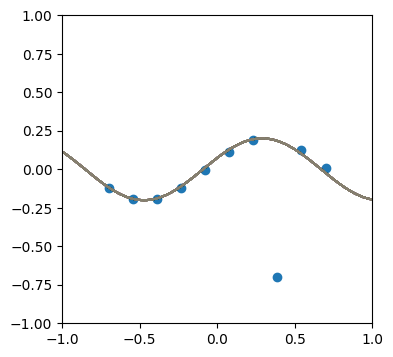

In [24]:
periodic_ex(Q)

Interesting! The posterior is full of good solutions but also contains a sprinkling of Nyquist-impostors!

...well, it used to. But changing the way the inlier_sigma is now inferred rather than prescribed has changed the quality of the posterior a great deal: Perhaps by allowing small sigmas, we have allowed a trace through which dominates all the others, weight-wise. We can get the old "curve-cloud" behavior back by fixing on 0.3 as the inlier sigma:

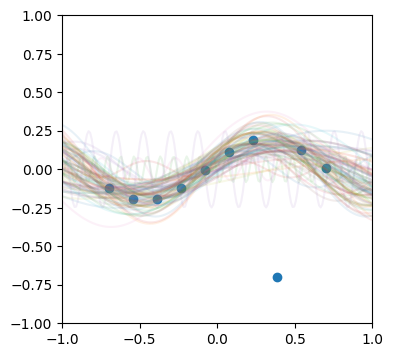

In [25]:
def periodic_ex2(F: Block):
    ys = (0.2 * jnp.sin(4 * xs + 0.3)).at[7].set(-0.7)
    fs = CurveFit(
        curve=Q,
        sigma_inlier=genjax.uniform(0.1, 0.2),
        p_outlier=genjax.uniform(0.05, 0.2),
    ).importance_sample(xs, ys, 100000, 100)
    plot_posterior(fs, xs, ys)

periodic_ex2(P)

## Conclusion

I like this framework more than I thought I would when I started it. A wise man once said it is easier to write probabilistic programming languages than probabilistic programs and I found it so. The experience of doing this helped me to understand JAX better. In particular, the idea of creating a custom `Pytree` object seemed exotic to me before I started this, but: if you want to have a Generative Function that produces something other than an array, while retaining full JAX-compatibility, it's exactly what you should do. In this case, the DSL allows the construction and composition of Generative Functions that sample from distributions of real-valued functions on the real line, and that's what curve fitting is about.

## Grand Finale: the ascending periodic example

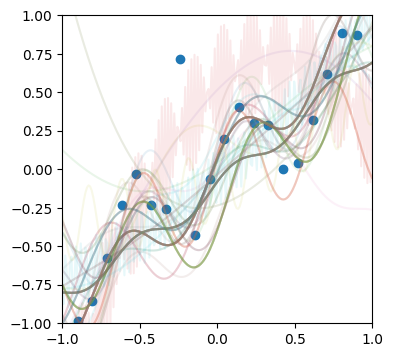

In [26]:
def ascending_periodic_ex(F: Block):
    xs = jnp.linspace(-0.9,0.9,20)
    ys = (0.7 * xs + 0.3 * jnp.sin(9 * xs + 0.3)).at[7].set(0.75)
    ys += jax.random.normal(key=jax.random.PRNGKey(22), shape=ys.shape) * 0.07
    fs = CurveFit(
        curve=F,
        sigma_inlier=sigma_inlier,
        p_outlier=p_outlier
    ).importance_sample(xs, ys, 1000000, 100)
    plot_posterior(fs, xs, ys)

ascending_periodic_ex(Q+P)

The posterior distribution here is very thin, suggesting that the priors are too broad (note that I had to increase to 1M samples to get this far, which took 12.6s on my machine). Nonetheless, importance sampling on the sum function was able to find very plausible candidates.

NB: actually that used to be true; now the posterior has a lot of interesting things in it (provoked in this instance I think by adding some noise to the y points)